In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
import math
from IPython.display import display, Markdown, Math

In [2]:
def vector2latex(vector, precision=5, pretext="", display_output=True):
    """replace with array_to_latex"""
    out_latex = "\n$$ " + pretext
    out_latex += "\\begin{bmatrix}\n"
    for amplitude in vector:
        amplitude = np.real_if_close(amplitude)
        amp_mod = np.mod(np.real(amplitude), 1)
        if (np.isclose(amp_mod, 0) or np.isclose(amp_mod, 1)) and np.isclose(np.imag(amplitude), 0):
            out_latex += str(int(np.round(amplitude))) + " \\\\\n"
        else:
            out_latex += '{:.{}f}'.format(amplitude, precision) + " \\\\\n"
    out_latex = out_latex[:-4] # remove trailing ampersands
    out_latex += "\end{bmatrix} $$"
    if display_output:
        display(Math(out_latex))
    else:
        return out_latex

<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
C:\Users\markw\AppData\Local\Temp\ipykernel_39748\1375264105.py:13: SyntaxWarning: invalid escape sequence '\e'
  out_latex += "\end{bmatrix} $$"


In [3]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [4]:
N=15
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)

In [5]:
def qpe_amod15(a):
    n_count = 3
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialise counting qubits in state |+>
    qc.x(3+n_count) # And ancilla register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    simulator = AerSimulator()
    qcc = transpile(qc, simulator)
    job = simulator.run(qcc,shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [6]:
N=15
np.random.seed(2) # This is to make sure we get reproduceable results
a = randint(2, N)
while gcd(a,N) != 1:
    a = randint(2,15)
print("a: %i"%a);

factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, 15), gcd(a**(r//2)+1, 15)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess != 1 and (15 % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True

a: 8

Attempt 1:
Register Reading: 010
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


In [7]:
a=13
phase = qpe_amod15(a)
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

Register Reading: 000
Corresponding Phase: 0.000000
1
[15, 1]


In [9]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

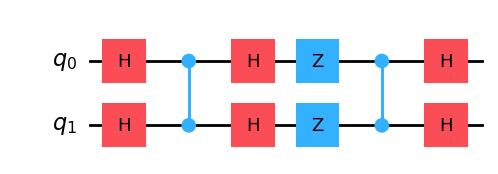

In [17]:
n = 2
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.cz(0,1) # Oracle
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw('mpl')

In [16]:
grover_circuit.save_statevector()
simulator = AerSimulator(method='statevector')
qcc = transpile(grover_circuit, simulator)
result = simulator.run(qcc,shots=1024).result()
statevec = result.get_statevector(0)
statevec =np.asarray(statevec)
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

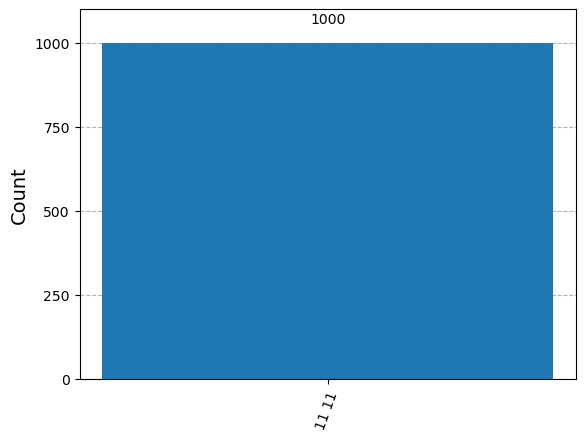

In [19]:
grover_circuit.measure_all()

simulator = AerSimulator()
qcc = transpile(grover_circuit, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())

In [20]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

In [21]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "$U_o$"

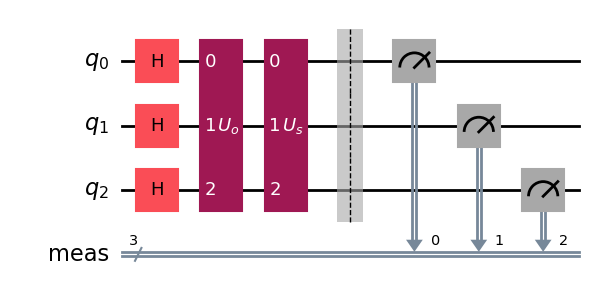

In [22]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw('mpl')

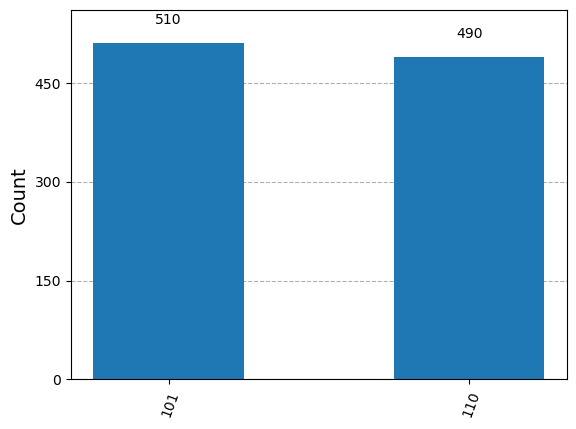

In [23]:
simulator = AerSimulator()
qcc = transpile(grover_circuit, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())

In [24]:
from qiskit.circuit.library import Diagonal

def grover_problem_oracle(n, variant=0, print_solutions=False):
    np.random.seed(variant)
    if n < 3:
        nsolutions = 1
    else:
        nsolutions = np.random.randint(1, np.ceil(2**n/4))
    diagonal_elements = [-1]*nsolutions + [1]*((2**n)-nsolutions)
    np.random.shuffle(diagonal_elements)
    oracle_gate = Diagonal(diagonal_elements)
    oracle_gate.name = "Oracle\nn=%i, var=%i" % (n, variant)
    if print_solutions:
        print("Solutions: ")
        for idx, e in enumerate(diagonal_elements):
            if e < 1:
                print("|%s>" % format(idx, "0%ib" %n))
    return(oracle_gate)

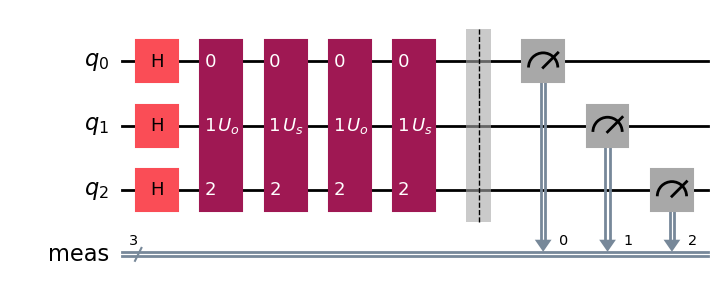

In [10]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw('mpl')

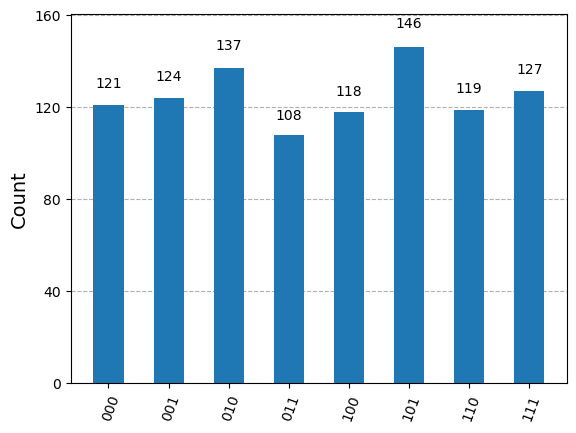

In [11]:
simulator = AerSimulator()
qcc = transpile(grover_circuit, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())

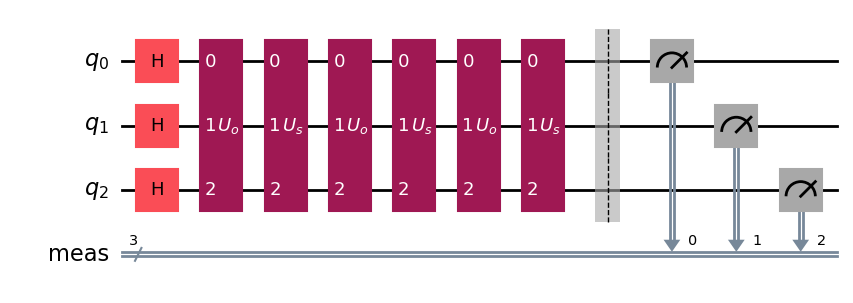

In [12]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw('mpl')

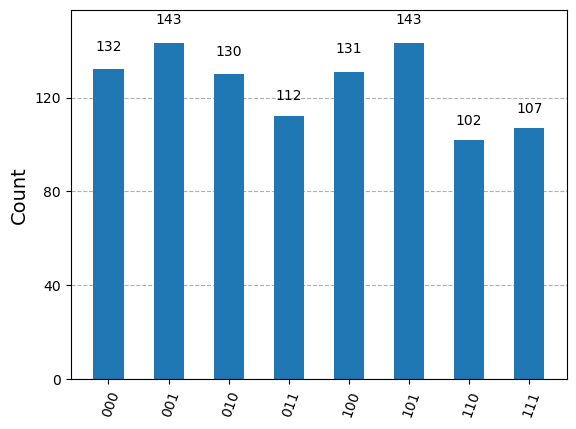

In [13]:
simulator = AerSimulator()
qcc = transpile(grover_circuit, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())